In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from influxdb_client import InfluxDBClient, Point, Dialect

import re

import time
import datetime

import warnings
from influxdb_client.client.warnings import MissingPivotFunction

import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
import matplotlib.colors as colors

# try:
#     # for Python2
#     from Tkinter import *   ## notice capitalized T in Tkinter 
# except ImportError:
#     # for Python3
#     from tkinter import *   ## notice lowercase 't' in tkinter here

pd.set_option('display.max_rows', 100)
import pandasql as ps
import sqlite3

In [2]:
#Read config file and load data into the variables

rx_dict = {
    'token': re.compile(r'var token = "(?P<token>.*)"\n'),
    'url': re.compile(r'var url = "(?P<url>.*)"\n'),
    'org': re.compile(r'var org = "(?P<org>.*)"\n'),
    'bucket': re.compile(r'var bucket = "(?P<bucket>.*)"\n'),
}

def _parse_line(line):
    """
    Do a regex search against all defined regexes and
    return the key and match result of the first matching regex

    """
    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            return key, match
    # if there are no matches
    return None, None



filepath = '/root/flexi-pipe/config.go'
# open the file and read through it line by line
with open(filepath, 'r') as file_object:
    line = file_object.readline()
    while line:
        # at each line check for a match with a regex
        key, match = _parse_line(line)

        if key == 'token':
            token = match.group('token')
        elif key == 'url':
            url = match.group('url')
        elif key == 'org':
            org = match.group('org')
        elif key == 'bucket':
            bucket = match.group('bucket')
        
        line = file_object.readline()


url="http://192.168.20.58:8086"

In [3]:
# Retrieve experiments data from csv
data = pd.read_csv('../experiments.csv', header=None)
df = pd.DataFrame(data)

#Rename columns
experiments = df.rename(columns={0: "start", 1: "end", 2: "topology", 3: "runtime", 4: "d", 5: "dlo", 6: "dhi", 7: "dscore", 8: "dlazy", 9: "dout", 10: "gossipFactor", 11: "initialDelay", 12: "interval"}, errors='raise')

#Correct timestamp
experiments["start"] = experiments["start"].str.slice(0, 27)
experiments["end"] = experiments["end"].str.slice(0, 27)

#String to timestamp
experiments['startUnix'] = pd.to_datetime(experiments["start"],format="%Y-%m-%d %H:%M:%S.%f").astype('int64') / 10**9
experiments['endUnix'] = pd.to_datetime(experiments["end"],format="%Y-%m-%d %H:%M:%S.%f").astype('int64') / 10**9

experiments['startUnix'] = pd.to_timedelta(experiments['startUnix'], unit='s').dt.total_seconds().astype(int)#.astype(str)
experiments['endUnix'] = pd.to_timedelta(experiments['endUnix'], unit='s').dt.total_seconds().astype(int)#.astype(str)

#Drop fields we don't mneed for the moment
exp = experiments.drop(columns=["runtime", "initialDelay"]).sort_values(by=["start"])

exp.head(100)

,start,end,topology,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,startUnix,endUnix
0,2023-08-01 18:12:39.9235463,2023-08-01 18:27:39.9823849,validator,8,6,12,4,8,2,0.25,0.5,1690913559,1690914459
1,2023-08-01 18:31:11.7897611,2023-08-01 18:46:11.8497848,validator,8,6,12,4,8,2,0.25,1.0,1690914671,1690915571
4,2023-08-01 19:26:50.4773509,2023-08-01 19:41:50.4791575,validator,12,6,12,4,8,2,0.25,1.0,1690918010,1690918910
2,2023-08-01 20:03:55.9990248,2023-08-01 20:18:56.0023639,validator,8,3,12,4,8,2,0.25,1.0,1690920235,1690921136
3,2023-08-01 20:22:28.8777816,2023-08-01 20:37:28.8852009,validator,8,6,12,6,8,2,0.25,1.0,1690921348,1690922248
5,2023-08-02 10:56:20.4955665,2023-08-02 11:11:20.4982340,general,8,6,12,4,8,2,0.25,0.5,1690973780,1690974680
6,2023-08-02 11:14:47.7918974,2023-08-02 11:29:47.8618204,general,8,6,12,4,8,2,0.25,1.0,1690974887,1690975787
7,2023-08-02 12:54:05.2745963,2023-08-02 13:09:05.2774139,unl,8,6,12,4,8,2,0.25,0.5,1690980845,1690981745
8,2023-08-02 13:12:29.3626010,2023-08-02 13:27:29.4399914,unl,8,6,12,4,8,2,0.25,1.0,1690981949,1690982849
9,2023-08-02 13:49:24.3574194,2023-08-02 14:04:24.3707622,unl,8,6,12,4,8,2,0.25,3.0,1690984164,1690985064


In [4]:
#Get times for different intervals
# intervals = exp["interval"].drop_duplicates().sort_values().reset_index(drop=True)
# intervals.head(10)

expTime = exp[exp['startUnix'].astype(int).between(1691423149,1691473008)]
expTime['experiment'] = expTime.index

expTime.head(20)

/tmp/ipykernel_33487/2014203358.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expTime['experiment'] = expTime.index


,start,end,topology,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,startUnix,endUnix,experiment
22,2023-08-07 15:45:49.6082919,2023-08-07 16:00:49.6665551,general,8,6,12,4,8,2,0.25,0.5,1691423149,1691424049,22
23,2023-08-07 16:04:21.6318119,2023-08-07 16:19:21.6346074,general,8,6,12,4,8,2,0.25,0.5,1691424261,1691425161,23
24,2023-08-07 16:22:53.6132934,2023-08-07 16:37:53.6715174,general,8,6,12,4,8,2,0.25,0.5,1691425373,1691426273,24
25,2023-08-07 16:41:26.1245354,2023-08-07 16:56:26.1290839,general,8,6,12,4,8,2,0.25,1.0,1691426486,1691427386,25
26,2023-08-07 16:59:58.1176366,2023-08-07 17:14:58.1206094,general,8,6,12,4,8,2,0.25,1.0,1691427598,1691428498,26
27,2023-08-07 17:18:30.6060026,2023-08-07 17:33:30.6091742,general,8,6,12,4,8,2,0.25,1.0,1691428710,1691429610,27
28,2023-08-07 17:37:02.4851057,2023-08-07 17:52:02.5670752,general,8,6,12,4,8,2,0.25,30.0,1691429822,1691430722,28
29,2023-08-07 17:55:34.7527963,2023-08-07 18:10:34.7603854,general,8,6,12,4,8,2,0.25,30.0,1691430934,1691431834,29
30,2023-08-07 18:14:06.9060147,2023-08-07 18:29:06.9662688,general,8,6,12,4,8,2,0.25,30.0,1691432046,1691432946,30
31,2023-08-07 18:32:38.9738532,2023-08-07 18:47:38.9763238,general,8,6,12,4,8,2,0.25,3.0,1691433158,1691434058,31


In [5]:
client = InfluxDBClient(url=url, token=token, org=org,  timeout=130_000)

# write_api = client.write_api(write_options=SYNCHRONOUS)
query_api = client.query_api()


In [6]:
publish = query_api.query_data_frame('from(bucket: "gs") '
                                        ' |> range(start: 1691423149, stop:1691436284) '
                                        ' |> filter(fn: (r) => r._measurement == "publishMessage") '
                                        ' |> group(columns: ["_measurement", "_field"], mode: "by") '
                                        ' |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")')
client.close()

print(publish)

        result  table                    _start                     _stop  \
0      _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   
1      _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   
2      _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   
3      _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   
4      _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   
...        ...    ...                       ...                       ...   
38659  _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   
38660  _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   
38661  _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   
38662  _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   
38663  _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   

                                 _time    _measurement  \
0     2023-08-07 

In [7]:
received = query_api.query_data_frame('from(bucket: "gs") '
                                        ' |> range(start: 1691423149, stop:1691436284) '
                                        ' |> filter(fn: (r) => r._measurement == "deliverMessage") '
                                        ' |> group(columns: ["_measurement", "_field"], mode: "by") '
                                        ' |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")')
client.close()

print(received)

         result  table                    _start                     _stop  \
0       _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   
1       _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   
2       _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   
3       _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   
4       _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   
...         ...    ...                       ...                       ...   
765189  _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   
765190  _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   
765191  _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   
765192  _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   
765193  _result      0 2023-08-07 15:45:49+00:00 2023-08-07 19:24:44+00:00   

                                  _time    _measurement  \
0   

In [8]:
publish = publish[['_time', 'messageID', 'topic']]
received = received[['_time', 'messageID', 'topic']]

joined = publish.merge(received, on=['messageID', 'topic'])

joined.head(10)

,_time_x,messageID,topic,_time_y
0,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.838953+00:00
1,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.837719+00:00
2,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.837979+00:00
3,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.838434+00:00
4,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.837981+00:00
5,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.837313+00:00
6,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.836370+00:00
7,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.838362+00:00
8,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.837795+00:00
9,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.836485+00:00


In [9]:
joined['diff'] = ((joined['_time_y'] - joined['_time_x'])/ pd.Timedelta(microseconds=1)).astype(int)

joined.head(10)

,_time_x,messageID,topic,_time_y,diff
0,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.838953+00:00,2906
1,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.837719+00:00,1672
2,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.837979+00:00,1932
3,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.838434+00:00,2387
4,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.837981+00:00,1934
5,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.837313+00:00,1266
6,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.836370+00:00,323
7,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.838362+00:00,2315
8,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.837795+00:00,1748
9,2023-08-07 15:45:50.836047+00:00,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,2023-08-07 15:45:50.836485+00:00,438


In [10]:
#Make the db in memory
conn = sqlite3.connect(':memory:')
#write the tables
joined.to_sql('joined', conn, index=False)
expTime.to_sql('expTime', conn, index=False)

qry = '''
    select  
        joined._time_x,
        joined.diff,
        joined.messageID,
        joined.topic,
        expTime.experiment,
        expTime.interval
    from
        joined join expTime on
        joined._time_x between expTime.start and expTime.end
    '''
dfNew = pd.read_sql_query(qry, conn)

dfNew = dfNew.set_index('experiment').rename(columns={"_time_x": "_time"})#.drop(columns=["messageID"])

# dfNew['_time'] = pd.to_datetime(dfNew["min"], format='mixed')
# dfNew['_min'] = pd.to_datetime(dfNew["_min"])

dfNew.head(20)

,_time,diff,messageID,topic,interval
experiment,,,,,
22,2023-08-07 15:45:50.836047+00:00,2906,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,0.5
22,2023-08-07 15:45:50.836047+00:00,1672,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,0.5
22,2023-08-07 15:45:50.836047+00:00,1932,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,0.5
22,2023-08-07 15:45:50.836047+00:00,2387,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,0.5
22,2023-08-07 15:45:50.836047+00:00,1934,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,0.5
22,2023-08-07 15:45:50.836047+00:00,1266,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,0.5
22,2023-08-07 15:45:50.836047+00:00,323,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,0.5
22,2023-08-07 15:45:50.836047+00:00,2315,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,0.5
22,2023-08-07 15:45:50.836047+00:00,1748,ACQIARIgI1fcHl95jQzZMa2FaRW3bAKVmBA6C+PstfIuT4...,validator:validations,0.5


In [11]:
#Average propagation time per interval
df = dfNew.drop(columns=['_time', 'messageID', 'topic'])

avgPropExp = df.groupby(['experiment']).agg('mean')
avgPropExp.reset_index(inplace=True)
avgPropExp = avgPropExp.drop(columns=['experiment'])

avgProp = avgPropExp.groupby(['interval']).agg({'diff':['mean','std']})
avgProp.columns = avgProp.columns.droplevel(0)
avgProp.reset_index(inplace=True)

avgProp.head(100)

,interval,mean,std
0,0.5,1135.055325,47.615615
1,1.0,1574.005088,617.500212
2,3.0,1344.582707,82.460728
3,30.0,1354.948996,192.728208


In [18]:
#Set yticks
y_labels = avgProp['interval'].astype(str).to_numpy()
y_size = y_labels.size

# # xticks need to have the same lenght
# x_min = avgProp['mean'].min().astype(int)
# x_max = avgProp['mean'].max().astype(int)
# interval = ((x_max-x_min)/y_size)

# x_labels = np.arange(x_min, x_max, interval)

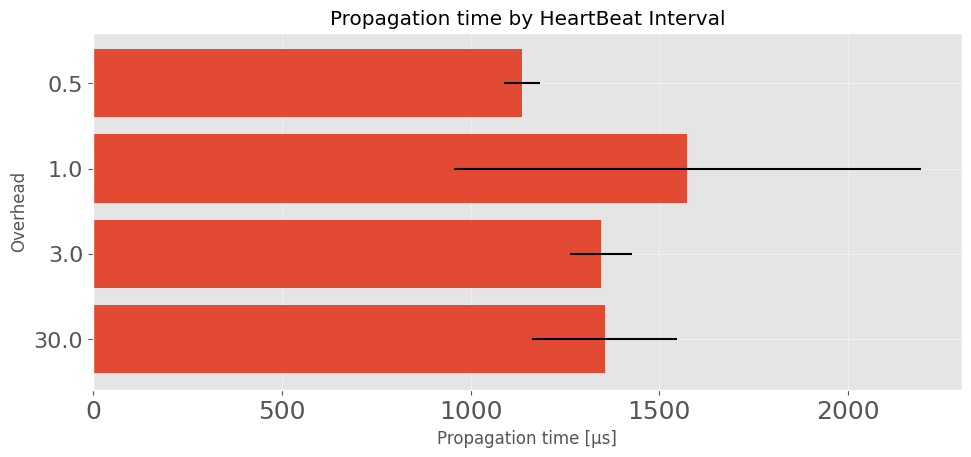

In [23]:
plt.style.use('ggplot')
# kwargs = dict(color=['hotpink'], alpha=0.9)#, density=True)

fig, ax = plt.subplots(constrained_layout=False)
ax.grid(alpha=0.4)

fig.tight_layout()
fig.subplots_adjust(left=0.19, bottom=0.09, right=0.98, top=0.92, wspace=0.17, hspace=0.17)

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

plt.gca().set(title='Propagation time by HeartBeat Interval', ylabel='Overhead', xlabel="Time [s]")

plt.rcParams.update({'font.size': 14})
# plt.hist([x1, x2, x6], **kwargs, label=['GS 1 topic', 'Vanilla', 'Squelching'])
# plt.legend(loc='upper center', bbox_to_anchor=(0.58, 1))
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2))

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)

fig.set_size_inches(11, 4.3)

#Set y axis labels
ax.barh(y_labels, avgProp['mean'], xerr=avgProp['std'], align='center')
ax.set_yticks(y_labels)
# plt.xticks(ticks=x_labels,labels=x_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Propagation time [μs]')

plt.show()